In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import Image as DisplayImage
from PIL import Image as PILImage
from fastai.vision import *
from fastai.vision.gan import *
import torch.nn as nn
import torch.nn.functional as F

You should set the following option to True if the notebook isn't located in the file system inside a clone of the git repo (with the needed Python modules available) it belongs to; i.e., it's running independently.

In [0]:
run_as_standalone_nb = True

In [3]:
# This cell needs to be executed before importing local project modules, like import core.gan
if run_as_standalone_nb:
    root_lib_path = os.path.abspath('generative-lab')
    if not os.path.exists(root_lib_path):
        !git clone https://github.com/davidleonfdez/generative-lab.git
    if root_lib_path not in sys.path:
        sys.path.insert(0, root_lib_path)
else:
    import local_lib_import

Cloning into 'generative-lab'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 510 (delta 5), reused 12 (delta 4), pack-reused 492
Receiving objects: 100% (510/510), 409.35 MiB | 13.89 MiB/s, done.
Resolving deltas: 100% (247/247), done.
Checking out files: 100% (52/52), done.


In [0]:
# Local project modules. Must be imported after local_lib_import or cloning git repo.
from core.gan import (CustomGANLearner, GANLossArgs, gan_loss_from_func, gan_loss_from_func_std, 
                      GeneratorFuncStateLoader, GenImagesSampler, load_gan_generator, 
                      load_gan_learner, save_gan_learner, train_checkpoint_gan)
from core.gan_display import display_gan_out_tensor
from core.gan_metrics import evaluate_models_fid, EvaluationItem, FIDCalculator
from core.gen_utils import PrinterProgressTracker
from core.nb_utils import output_file_link
from core.net_builders import interpolation_generator

`models_root` is used as the base path to save models.

In [0]:
models_root = './'

In [0]:
img_size = 64
img_n_channels = 3
batch_size = 64

# DATA

In Kaggle, you can easily add the CelebA dataset. For other environments, you probably need to manually download the dataset from https://drive.google.com/open?id=0B7EVK8r0v71pWEZsZE9oNnFzTm8.

In [0]:
real_images_path = Path('/kaggle/input/celeba-dataset/img_align_celeba/')
real_images_path

In [0]:
sample_img_path = next(real_images_path.glob('**/*.jpg'))
sample_img_path

In [0]:
im = PILImage.open(sample_img_path)
im.size

In [0]:
DisplayImage(filename=str(sample_img_path))

In [0]:
def get_data(path, bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

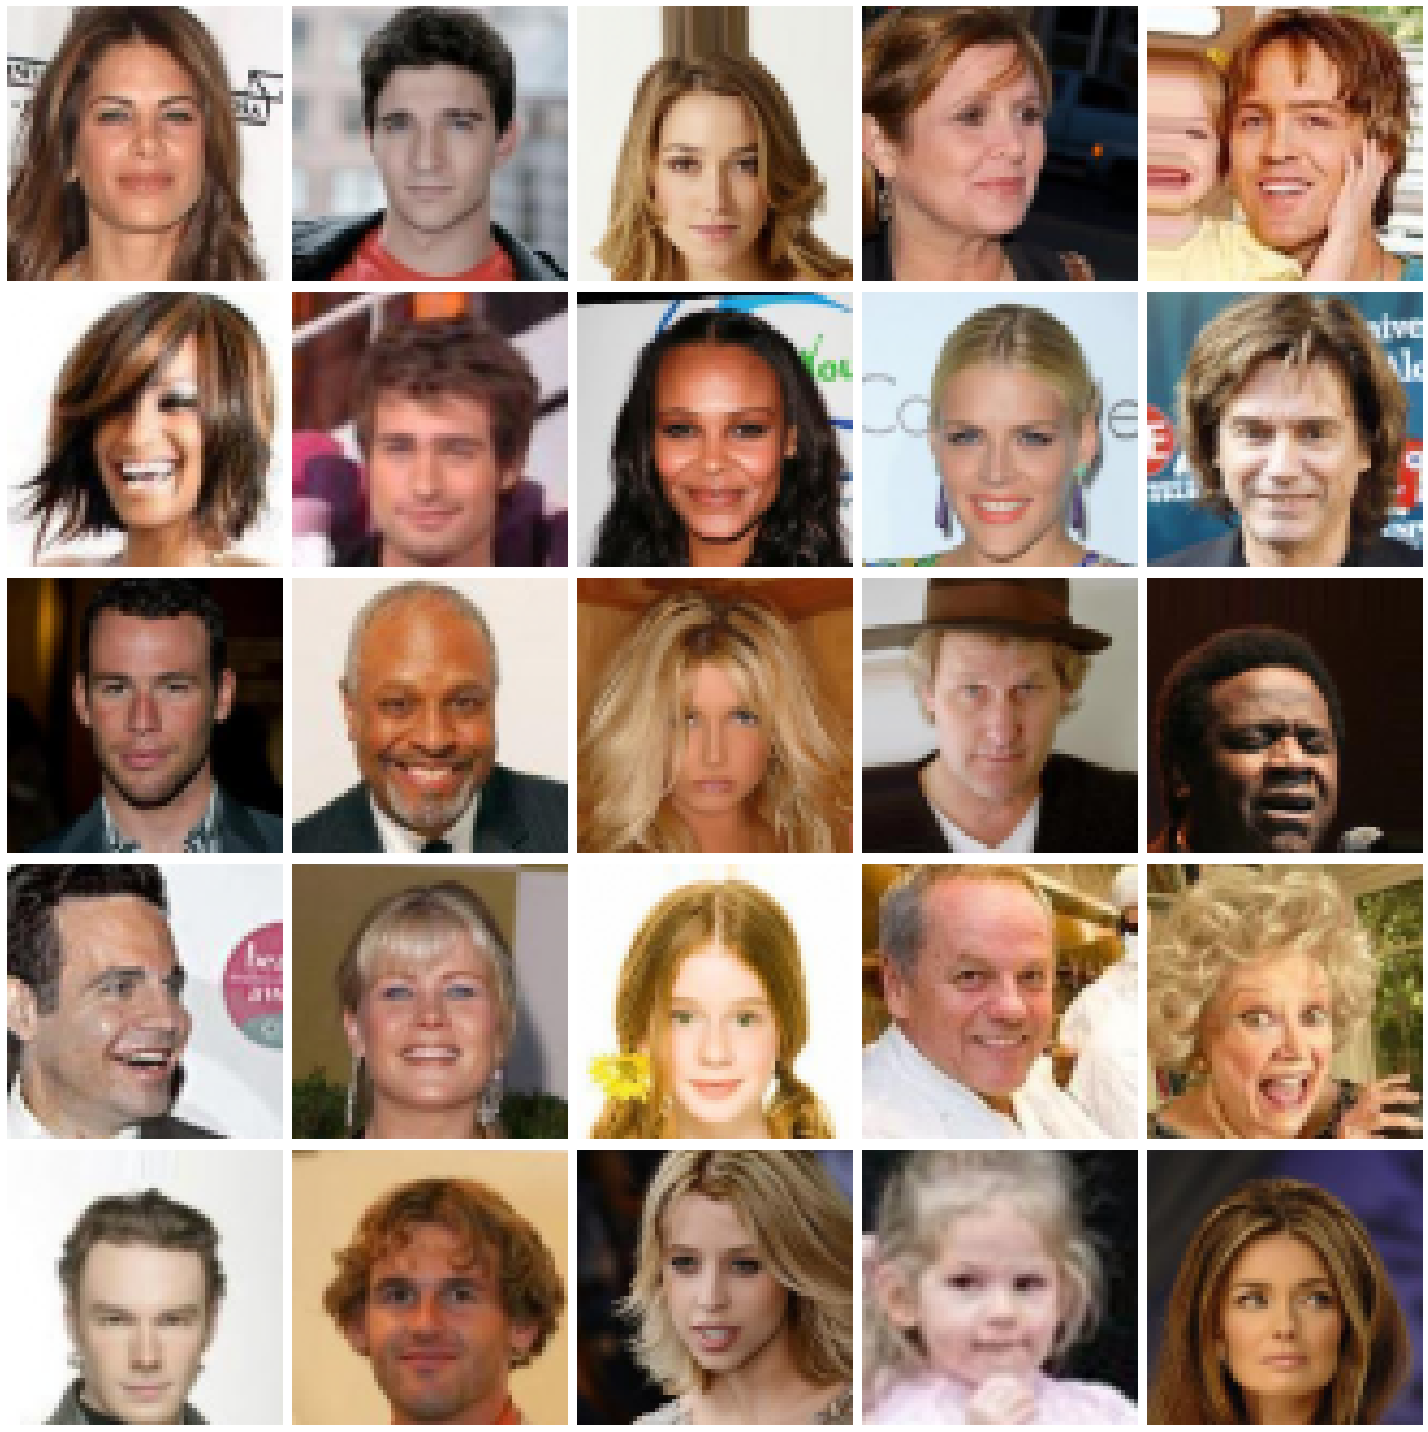

In [15]:
data = get_data(real_images_path, batch_size, img_size)
data.show_batch()

# GENERATOR

Generator uses interpolation followed with a regular convolution to upsample, instead of the traditional transpose convolution, in order to avoid checkerboard artifacts, as proposed here: https://distill.pub/2016/deconv-checkerboard/.

Input is bs x noise_sz * 1 * 1<br>
**n_features** is the number of feature maps (so kernels) generated after penultimate layer (the last layer of course outputs n_channels) if n_extra_layers = 0 . At the beginning there will be n_features * 2^(n_intermediate_conv_blocks), and this number will be reduced by half in any subsequent layer.

```
interpolation_generator(in_size:int, n_channels:int, noise_sz:int=100,  
                        n_features:int=64, n_extra_layers:int=0, 
                        dense:bool=False, upsample_mode:str='bilinear', 
                        **conv_kwargs) -> nn.Module:
```

In [0]:
generator = interpolation_generator(img_size, img_n_channels)

Test the generator. Should return 2 x img_n_channels x img_size x img_size

In [0]:
generator(torch.rand(2, 100, 1, 1)).size()

# CRITIC

Basic critic

**n_features** is the number of feature maps (so kernels) generated after first layer (from the n_channels of the input). This number will be doubled in any subsequent layer.

`basic_critic(in_size:int, n_channels:int, n_features:int=64, n_extra_layers:int=0, **conv_kwargs)`

In [0]:
critic = basic_critic(img_size, img_n_channels)

Test the critic. Should return [1].

In [0]:
critic(torch.rand(2, 3, 64, 64)).size()

# GAN LEARNER

In [0]:
def gen_loss_func(*args): return 0
crit_loss_func = nn.BCEWithLogitsLoss()

losses = gan_loss_from_func_std(gen_loss_func, crit_loss_func)

In [0]:
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*losses))

# TRAINING

* The parameters of a trained model can be saved with `save_gan_learner`.
* A training run can resumed (using weights saved during a previous session) with `load_gan_learner`. For example:
        load_gan_learner(learner, models_root + 'interpBilinearGANTr1_40ep.pth')
    This must be executed after instantiating the learner and BEFORE running `learner.fit()`.

* Another alternative to launch a long training run is the method `save_checkpoint_gan`. It will automatically save the weights every `n_epochs_save_split` epochs.

## Bilinear interpolation

### TRAINING 1: lr=1e-4, wd=0, Adam(beta1=0, beta2=0.99)

Not worth it. It never works as well as with (at least) 1 extra layer.

In [0]:
lr = 1e-4
data = get_data(real_images_path, batch_size, img_size)
generator = interpolation_generator(img_size, img_n_channels)
critic = basic_critic(img_size, img_n_channels)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*losses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(20, lr)
save_gan_learner(learner, models_root + 'interpBilinearGAN-celeba-tr1_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

### TRAINING 2: lr=2e-4, wd=0, Adam(beta1=0, beta2=0.99)

Not worth it. It never works as well as with (at least) 1 extra layer.

In [0]:
lr = 2e-4
data = get_data(real_images_path, batch_size, img_size)
generator = interpolation_generator(img_size, img_n_channels)
critic = basic_critic(img_size, img_n_channels)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*losses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(20, lr)
save_gan_learner(learner, models_root + 'interpBilinearGAN-celeba-tr2_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

### TRAINING 3: lr=2e-4, wd=0, Adam(beta1=0, beta2=0.99), 1 extra layer

In [0]:
lr = 2e-4
data = get_data(real_images_path, batch_size, img_size)
generator = interpolation_generator(img_size, img_n_channels, n_extra_layers=1)
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*losses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBilinearGAN-celeba-tr3_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBilinearGAN-celeba-tr3_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBilinearGAN-celeba-tr3_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBilinearGAN-celeba-tr3_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

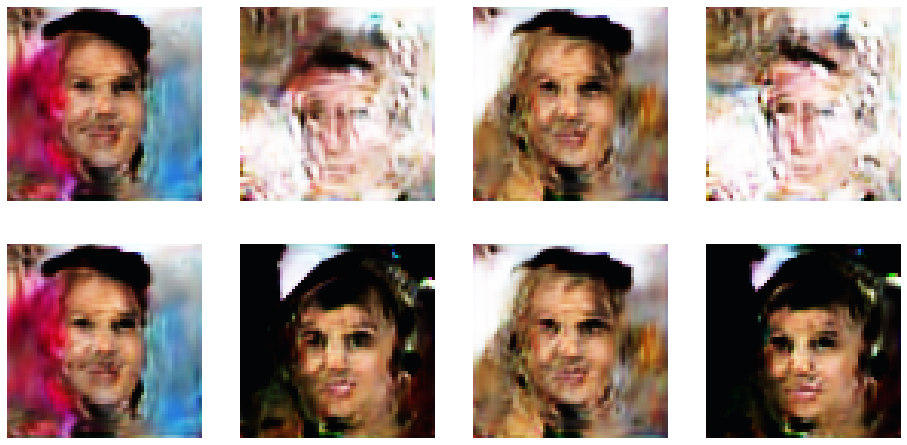

In [17]:
generator = interpolation_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'interpBilinearGAN-celeba-tr3_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

### TRAINING 4: WGAN lr=2e-4, wd=0, Adam(beta1=0, beta2=0.99), 1 extra layer

In [0]:
lr = 2e-4
data = get_data(real_images_path, batch_size, img_size)
generator = interpolation_generator(img_size, img_n_channels, n_extra_layers=1)
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBilinearGAN-celeba-tr4_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBilinearGAN-celeba-tr4_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBilinearGAN-celeba-tr4_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBilinearGAN-celeba-tr4_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

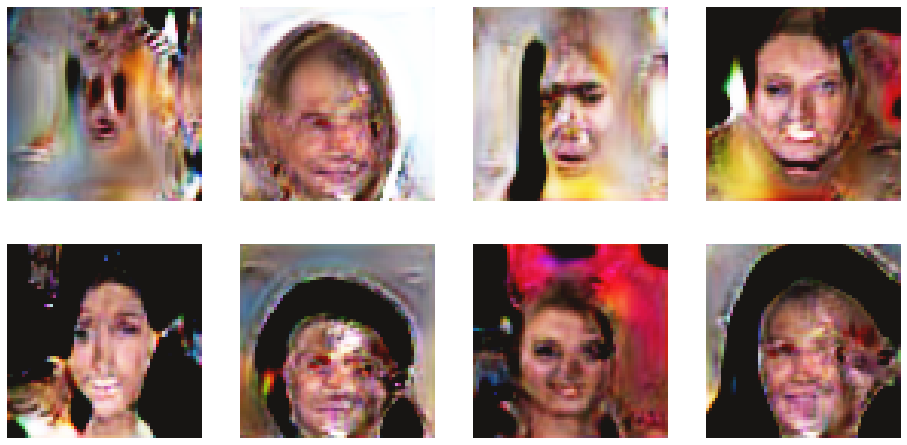

In [18]:
generator = interpolation_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'interpBilinearGAN-celeba-tr4_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

## Bicubic interpolation

### TRAINING 1: lr=2e-4, wd=0, Adam(beta1=0, beta2=0.99), 1 extra layer

In [0]:
lr = 2e-4
data = get_data(real_images_path, batch_size, img_size)
generator = interpolation_generator(img_size, img_n_channels, n_extra_layers=1, upsample_mode='bicubic')
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*losses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBicubicGAN-celeba-tr1_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBicubicGAN-celeba-tr1_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBicubicGAN-celeba-tr1_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBicubicGAN-celeba-tr1_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

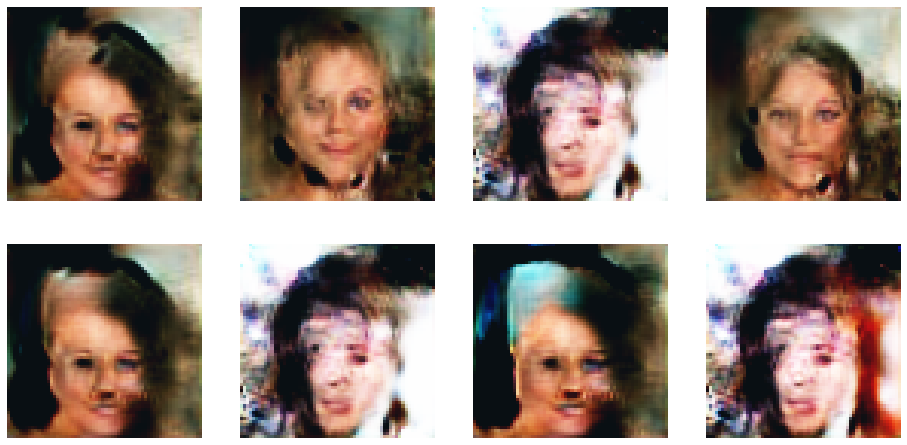

In [19]:
generator = interpolation_generator(img_size, img_n_channels, n_extra_layers=1, upsample_mode='bicubic')
load_gan_generator(generator, models_root + 'interpBicubicGAN-celeba-tr1_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

### TRAINING 2: WGAN lr=2e-4, wd=0, Adam(beta1=0, beta2=0.99), 1 extra layer

In [0]:
lr = 2e-4
data = get_data(real_images_path, batch_size, img_size)
generator = interpolation_generator(img_size, img_n_channels, n_extra_layers=1, upsample_mode='bicubic')
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBicubicGAN-celeba-tr2_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBicubicGAN-celeba-tr2_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBicubicGAN-celeba-tr2_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpBicubicGAN-celeba-tr2_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

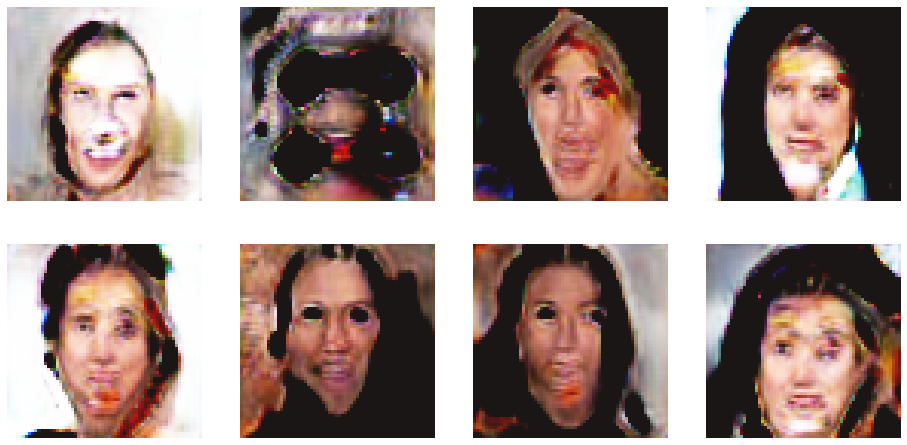

In [22]:
generator = interpolation_generator(img_size, img_n_channels, n_extra_layers=1, upsample_mode='bicubic')
load_gan_generator(generator, models_root + 'interpBicubicGAN-celeba-tr2_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

## Nearest neighboor

### TRAINING 1: lr=2e-4, wd=0, Adam(beta1=0, beta2=0.99), 1 extra layer

In [0]:
lr = 2e-4
data = get_data(real_images_path, batch_size, img_size)
generator = interpolation_generator(img_size, img_n_channels, n_extra_layers=1, upsample_mode='nearest')
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*losses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpNearestGAN-celeba-tr1_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpNearestGAN-celeba-tr1_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpNearestGAN-celeba-tr1_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpNearestGAN-celeba-tr1_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

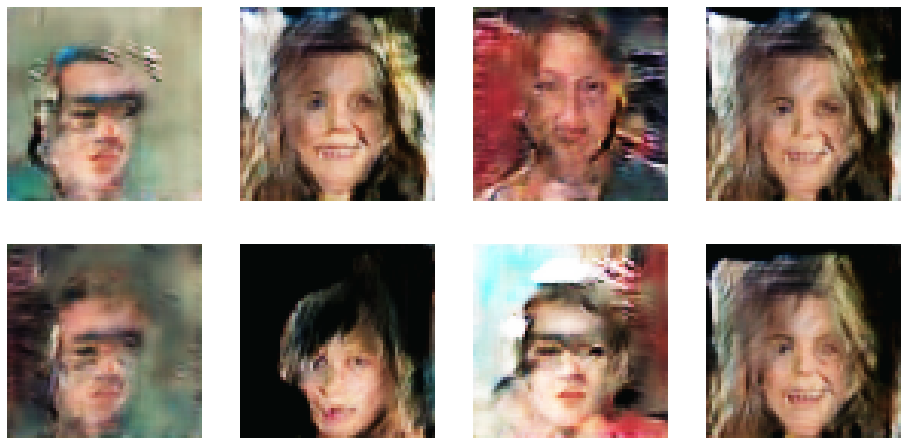

In [23]:
generator = interpolation_generator(img_size, img_n_channels, n_extra_layers=1, upsample_mode='nearest')
load_gan_generator(generator, models_root + 'interpNearestGAN-celeba-tr1_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

### TRAINING 2: WGAN lr=2e-4, wd=0, Adam(beta1=0, beta2=0.99), 1 extra layer

In [0]:
lr = 2e-4
data = get_data(real_images_path, batch_size, img_size)
generator = interpolation_generator(img_size, img_n_channels, n_extra_layers=1, upsample_mode='nearest')
critic = basic_critic(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner.wgan(data, generator, critic, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpNearestGAN-celeba-tr2_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpNearestGAN-celeba-tr2_10ep.pth')

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.662327,#na#,0.486506,-0.889697,11:09
1,-0.634833,#na#,0.484657,-0.872089,10:14
2,-0.631471,#na#,0.474545,-0.850816,10:00
3,-0.604938,#na#,0.463997,-0.834056,09:55
4,-0.624169,#na#,0.452827,-0.836313,10:11


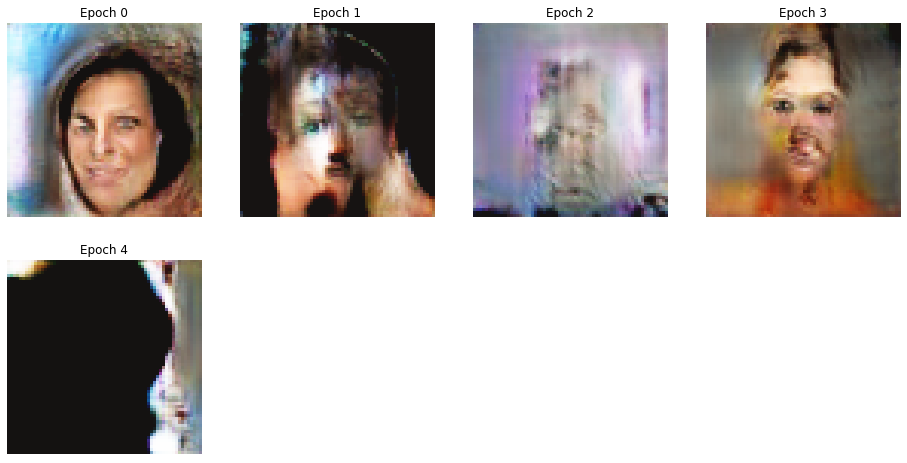

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpNearestGAN-celeba-tr2_15ep.pth')

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.614885,#na#,0.446687,-0.823338,10:11
1,-0.587128,#na#,0.447324,-0.810841,10:02
2,-0.611404,#na#,0.435010,-0.816508,10:06
3,-0.581502,#na#,0.428225,-0.793220,10:10
4,-0.580305,#na#,0.429286,-0.779457,10:12


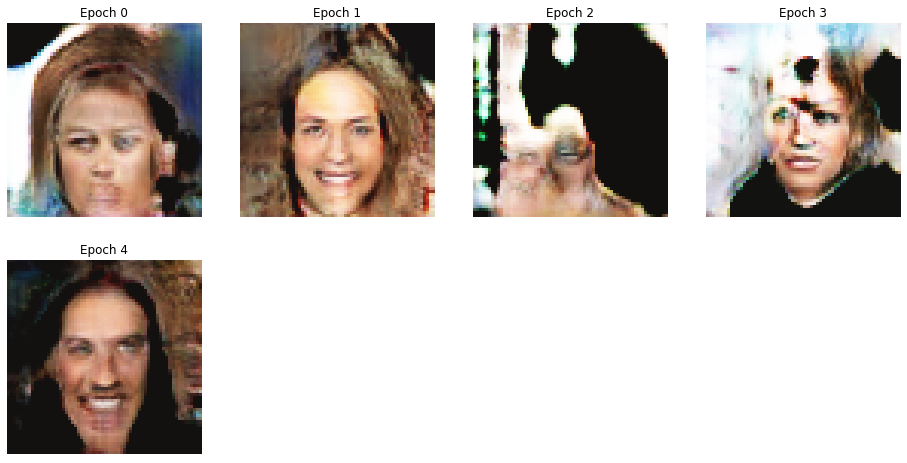

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'interpNearestGAN-celeba-tr2_20ep.pth')

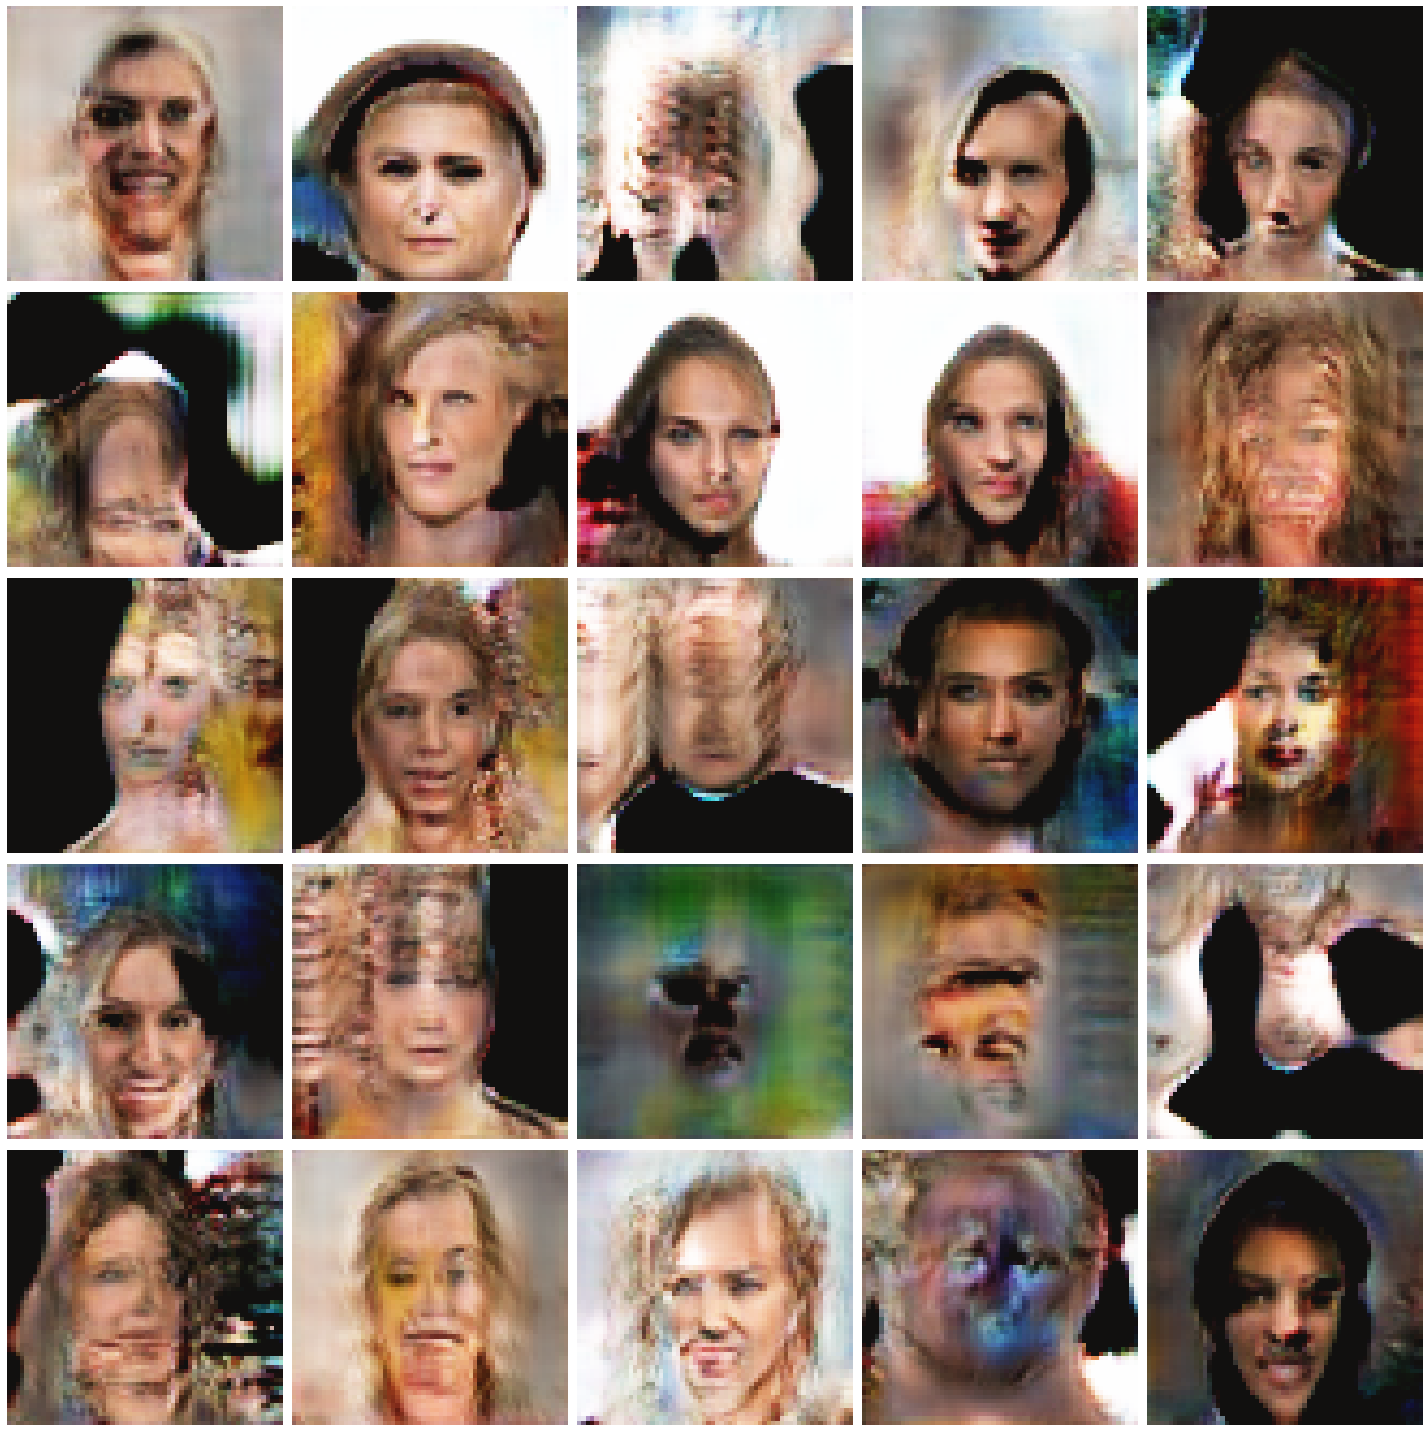

In [0]:
learner.show_results(ds_type=DatasetType.Train)